In [38]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import gan_helper
import sklearn.model_selection
import torch
import models
import util
import config
import viz
import os
import scipy.stats
GAN = gan_helper.Generator() # initializes gan
print('Done!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Done!


**note - look at some of the plots in `analyze_inn` nb to help with this**

# load latent-mapping model

In [3]:
PROCESSED_DIR = 'processed'
fname = config.BEST_MODEL
df = pd.read_pickle(oj(PROCESSED_DIR, fname + '.pkl'))
p = pkl.load(open(oj(PROCESSED_DIR, fname + '_params.pkl'), 'rb'))
state_dicts = pkl.load(open(oj(PROCESSED_DIR, fname + '_weights.pkl'), 'rb'))
d = df[['epochs', 'mse_test', 'indep_corr_test']].infer_objects().round(2)
d[(d['mse_test'] < 0.5) & (d['indep_corr_test'] < 0.3)]

epochs    mse_test indep_corr_test
5   10000   0.3069094      0.28904143
6   12000  0.35443076      0.16762806
7   14000   0.4434507     0.058173716

In [4]:
# actually select a model to load
key_epoch = 10000
state_dict = state_dicts[key_epoch]
device = 'cpu'
LATENT_DIM = 512
m = models.get_INN(num_layers=p['num_layers'], hidden_size=p['hidden_size'],
                   input_size=LATENT_DIM).to(device)
m.load_state_dict(state_dict)

Node 'coupling_0' takes the following inputs:
	 Output #0 of node 'input' with dims (512,)

Node 'coupling_1' takes the following inputs:
	 Output #0 of node 'coupling_0' with dims (512,)

Node 'coupling_2' takes the following inputs:
	 Output #0 of node 'coupling_1' with dims (512,)

Node 'output' takes the following inputs:
	 Output #0 of node 'coupling_2' with dims (512,)



<All keys matched successfully>

**let's test the invertible dnn**

inversion succesful!


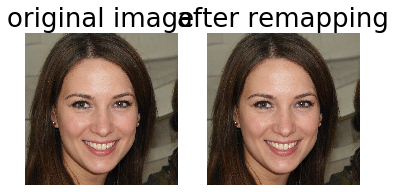

In [45]:
N_IMS = 5
np.random.seed(10)
z0 = np.random.randn(1, 512)
a = m(torch.Tensor(z0))
z = util.detach(m(a, rev=True))
assert np.allclose(z0, z, atol=1e-3), 'inversion was unsuccesful'
print('inversion succesful!')
images = GAN.gen(np.vstack((z0, z)))

R = 1
C = 2
plt.subplot(R, C, 1)
plt.title('original image')
util.imshow(images[0])

plt.subplot(R, C, 2)
plt.title('after remapping')
util.imshow(images[1])

plt.show()
# attrs = np.zeros((N_IMS, 512))

**let's walk in face space (using shared z)**

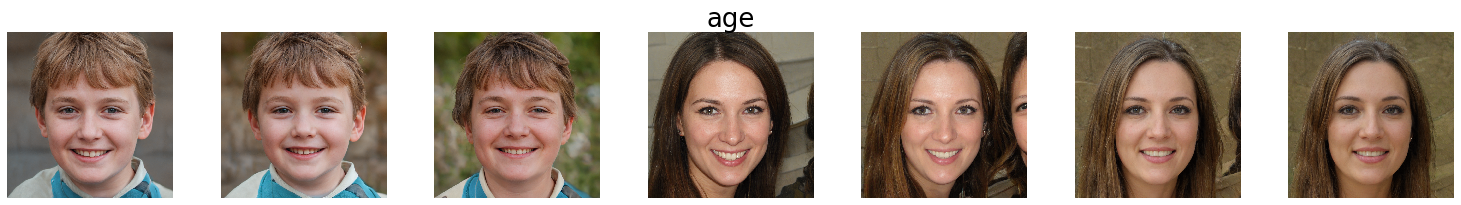

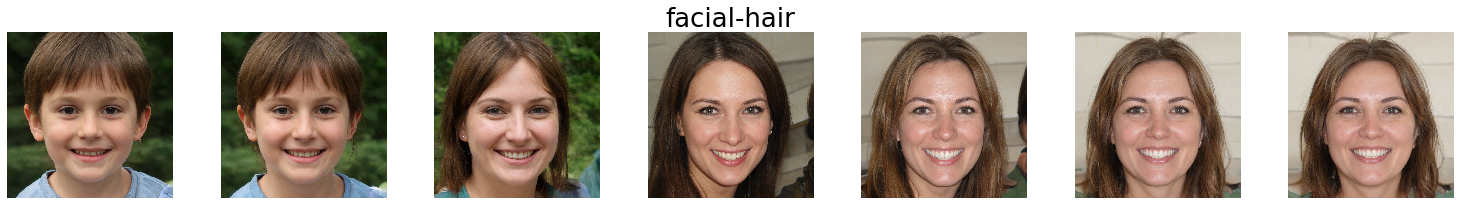

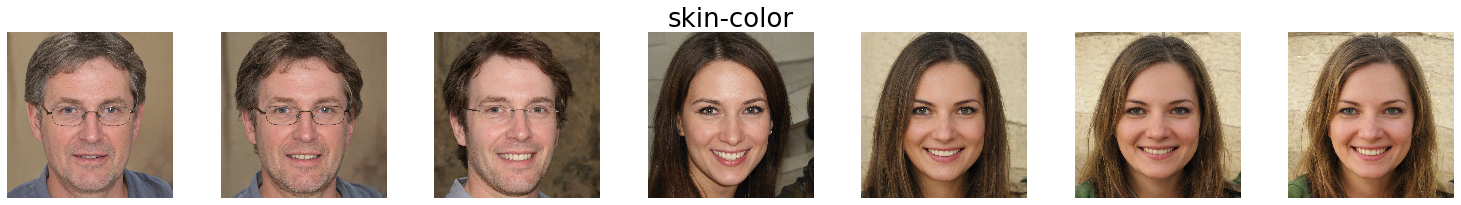

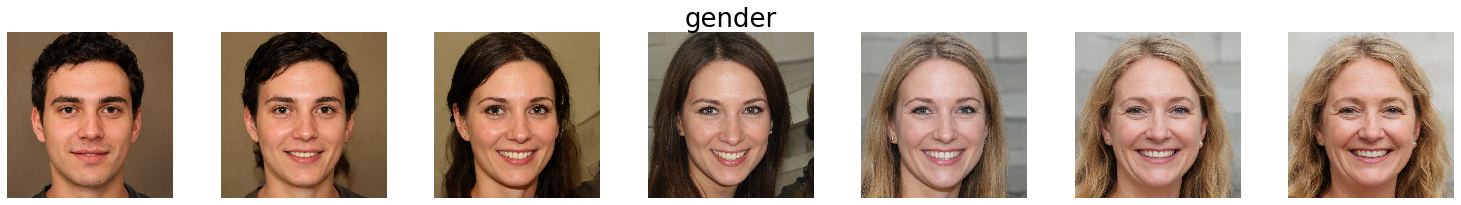

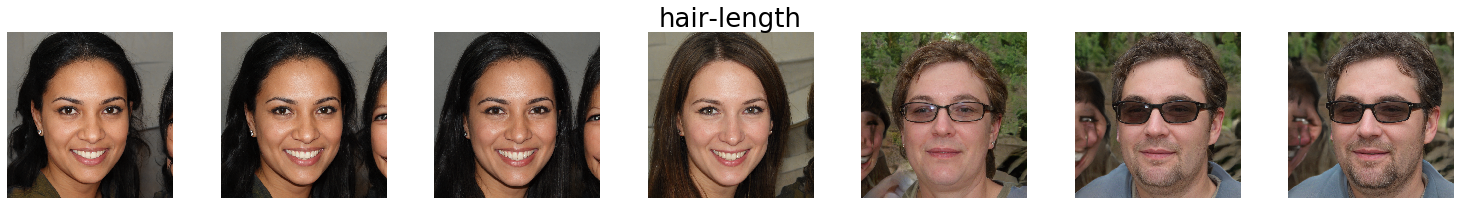

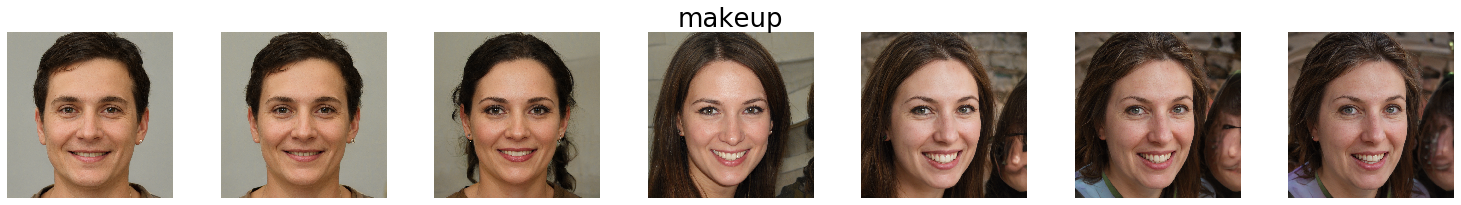

In [53]:
# min/max to vary these attributes
attr_bounds = { 
    'age': (-2, 2),
    'facial-hair': (-2, 2),
    'skin-color': (-2, 2),
    'gender': (-1, 1),
    'hair-length': (-2, 2),
    'makeup': (-2, 2)
}
# min/max to vary these attributes
attr_deltas = { 
    'age': 2,
    'facial-hair': 2,
    'skin-color': 2,
    'gender': 1,
    'hair-length': 2,
    'makeup': 2
}

# z0 = np.zeros((1, 512)) #X[1:2] * 0
N_IMS = 7 # should be odd
a = m(torch.Tensor(z0)) # 1, 512
for attr_index, attr in enumerate(config.ATTRS):
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 1
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
        a_arr[j, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    images = GAN.gen(np.vstack(zs))
    util.plot_row(images, suptitle=attr)
    plt.show()

# using projected images (full z)

**get a latent from embedding**

In [78]:
fnames = sorted([fname 
          for fname in os.listdir(config.REAL_LATENT_ENCODINGS_DIR)
          if '.npy' in fname])
latents = np.load(oj(config.REAL_LATENT_ENCODINGS_DIR, fnames[1]))
z0 = np.expand_dims(latents, 0)

In [ ]:
# print('z at different scales are not the same')
# viz.corrplot(np.corrcoef(latents))
# plt.colorbar()
# plt.show()

In [ ]:
# im = GAN.gen_full(z0)
# util.imshow(im)

**let's walk in face space**

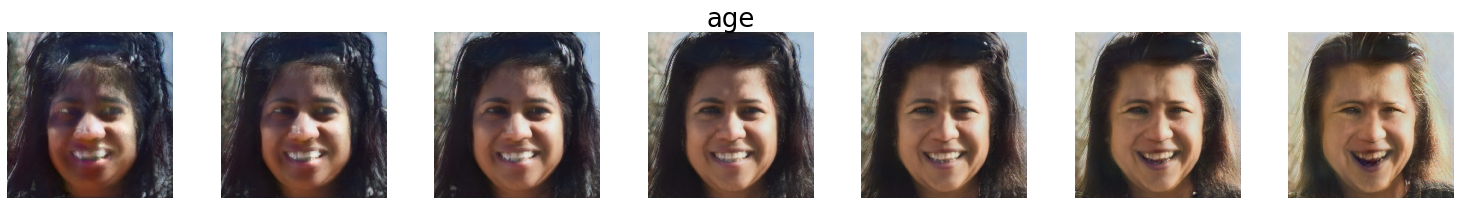

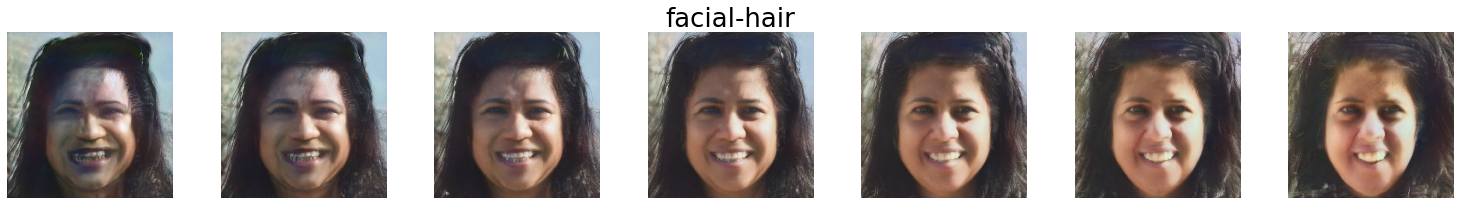

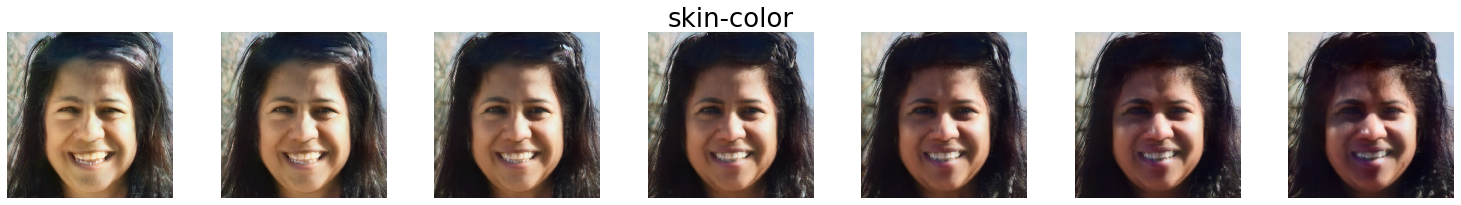

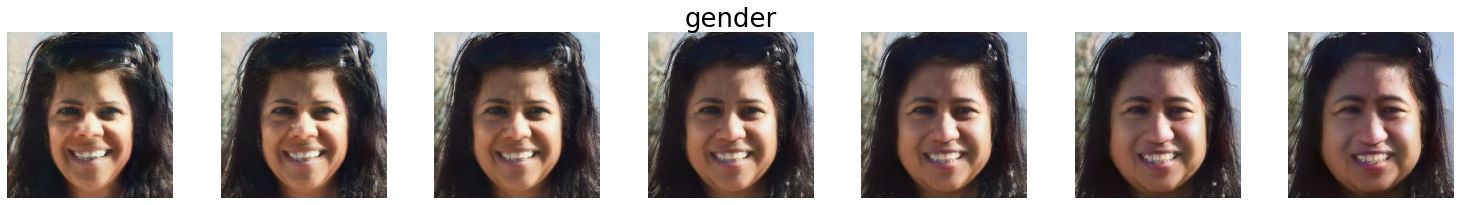

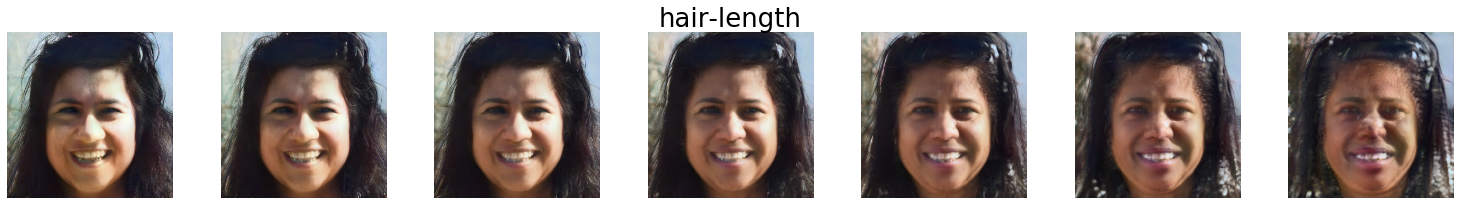

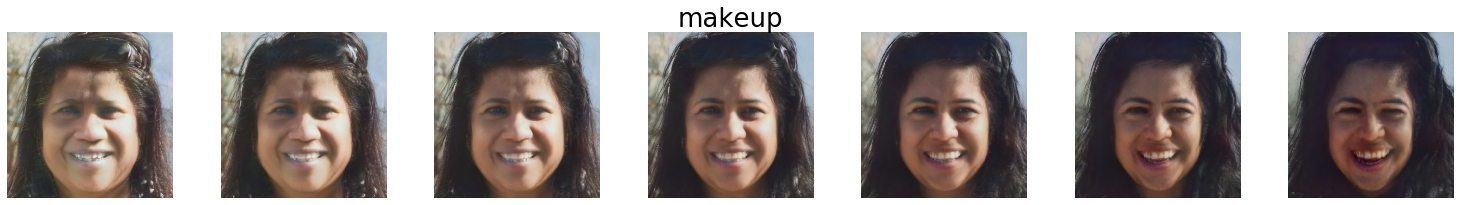

In [88]:
z0 = np.squeeze(z0)
# z0: (18, 512)
N_IMS = 7 # should be odd
MULT = 18
a = m(torch.Tensor(z0))
for attr_index, attr in enumerate(config.ATTRS):
    
    # get a mapping for z0
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 0.05
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
#         a_arr[j * MULT: j * MULT + 17, attr_index] += diff * mult * delta
        a_arr[j * MULT: (j + 1) * MULT, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    zs = zs.reshape(N_IMS, MULT, -1).squeeze()
    images = GAN.gen_full(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()